## A Comparison of Deep Learning Methods for Bitcoin Price Prediction

This notebook demonstrates the prediction of the bitcoin price by different deep learning models. These models:

1. One Layer LSTM
2. 2-layers LSTM Neural Network
3. GRU Model
4. Conv1D+LSTM Hybrid Model
5. Dilated-Conv + LSTM Hybrid Model

### Load Libraries

In [97]:
#importing the relevant libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM
from keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D , MaxPooling1D, AtrousConvolution1D
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time
from pandas import DataFrame
from keras.utils import plot_model
from IPython.display import Image
from IPython.core.display import HTML

import math

### Load the Dataset and Data Preprocessing

In [101]:
data = pd.read_csv("bitcoin_ticker.csv")

In [102]:
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


In [103]:
data['rpt_key'].value_counts()

btc_usd       125438
eth_btc        62719
btc_krw        62719
etc_krw        62719
eth_krw        62719
ltc_usd        62719
btc_jpy        62719
btc_eur        62719
fx_btc_jpy     62719
Name: rpt_key, dtype: int64

#### Subset USD

In [104]:
df = data.loc[(data['rpt_key'] == 'btc_usd')]

In [105]:
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


#### Convert datetime_id to data type and filter dates greater than  2017-06-28 00:00:00

In [106]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [107]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

In [108]:
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
77762,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.0,2473.19,20719.583592
77763,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.0,2780.62,2265.557866
77764,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.0,2473.19,20732.082581
77765,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.0,2780.62,2262.618866
77766,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.0,2473.19,20665.357191


#### We require only the last value, so we subset that and convert it to numpy array

In [109]:
df = df[['last']]

In [110]:
dataset = df.values
dataset = dataset.astype('float32')

In [111]:
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]], dtype=float32)

Neural networks are sensitive to input data, especiallly when we are using activation functions like sigmoid or tanh activation functions are used. So we rescale our data to the range of 0-to-1, using MinMaxScaler;

In [112]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [113]:
dataset

array([[0.1997695 ],
       [0.49828053],
       [0.18666792],
       ...,
       [0.29587936],
       [0.15456724],
       [0.29587936]], dtype=float32)

In [114]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

31942 15734


Now let us define the function called create_dataset, which take two inputs, 

1. Dataset - numpy array that we want to convert into a dataset
2. look_back - number of previous time steps to use as input variables to predict the next time period


In [115]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [116]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [117]:
trainX

array([[0.1997695 , 0.49828053, 0.18666792, ..., 0.4975314 , 0.19973087,
        0.4860053 ],
       [0.49828053, 0.18666792, 0.4855442 , ..., 0.19973087, 0.4860053 ,
        0.18442059],
       [0.18666792, 0.4855442 , 0.18251848, ..., 0.4860053 , 0.18442059,
        0.48598576],
       ...,
       [0.53376245, 0.6943617 , 0.53105354, ..., 0.7082124 , 0.5205841 ,
        0.7081547 ],
       [0.6943617 , 0.53105354, 0.70823145, ..., 0.5205841 , 0.7081547 ,
        0.52665424],
       [0.53105354, 0.70823145, 0.5332055 , ..., 0.7081547 , 0.52665424,
        0.7081547 ]], dtype=float32)

In [118]:
trainY

array([0.18442059, 0.48598576, 0.19208527, ..., 0.52665424, 0.7081547 ,
       0.5206418 ], dtype=float32)

In [119]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [120]:
print("X_train", trainX.shape)
print("y_train",trainY.shape)
print("X_test", testX.shape)
print("y_test", testY.shape)

X_train (31931, 1, 10)
y_train (31931,)
X_test (15723, 1, 10)
y_test (15723,)


### Build our Models

In [123]:
# One layer LSTM Neural Network
def model1():
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    return model

# 2-layers LSTM Neural Network
def model2():
    model = Sequential()
    model.add(LSTM(4,return_sequences = True,input_shape=(1, look_back)))
    model.add(Dropout(0.2))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Dense(1))
    return model

# GRU Model
def model3():
    model = Sequential()
    model.add(GRU(256, input_shape=(1, look_back)))
    model.add(Dense(1))
    return model

# LSTM+Conv1D Hybrid Model
def model4():
    model = Sequential()
    model.add(Dense(128,input_shape=(1,10)))
    model.add(Conv1D(filters = 80, kernel_size= 1,padding='same', activation='relu', kernel_initializer="glorot_uniform"))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(filters = 48,kernel_size = 1,padding='same', activation='relu', kernel_initializer="glorot_uniform"))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    #model.add(Dropout(0.2))
    model.add(LSTM(32,return_sequences=True))
    model.add(LSTM(16,return_sequences=False))
    model.add(Dense(32, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    return model

# Dilated-Conv + LSTM Hybrid Model
def model5():
    model = Sequential()
    model.add(AtrousConvolution1D(64, 5, atrous_rate=2, border_mode='same', input_shape= (1,10)))
    model.add(MaxPooling1D(pool_length=2,padding='same'))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(AtrousConvolution1D(32, 3, atrous_rate=2, border_mode='same'))
    model.add(MaxPooling1D(pool_length=2,padding='same'))
    model.add(Flatten())
    model.add(Dense(output_dim=1))
    model.add(Activation('linear'))
    return model

### Training - Comparison of these methods

C:\Users\alisu\Anaconda3\lib\site-packages\keras\legacy\layers.py:290: UserWarning: The `AtrousConvolution1D` layer  has been deprecated. Use instead the `Conv1D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution1D` layer '
C:\Users\alisu\Anaconda3\lib\site-packages\keras\legacy\layers.py:294: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 5, input_shape=(1, 10), dilation_rate=2, padding="same")`
  return Conv1D(*args, **kwargs)
C:\Users\alisu\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(padding="same", pool_size=2)`
C:\Users\alisu\Anaconda3\lib\site-packages\keras\legacy\layers.py:294: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, dilation_rate=2, padding="same")`
  return Conv1D(*args, **kwargs)
C:\Users\alisu\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `MaxPooling1D` call to the K

--------------------------------------------------------------------------------
Train on 25544 samples, validate on 6387 samples
Epoch 1/10
 - 8s - loss: 0.1605 - val_loss: 0.0098
Epoch 2/10
 - 0s - loss: 0.0055 - val_loss: 0.0017
Epoch 3/10
 - 0s - loss: 0.0036 - val_loss: 0.0013
Epoch 4/10
 - 0s - loss: 0.0027 - val_loss: 9.5482e-04
Epoch 5/10
 - 0s - loss: 0.0019 - val_loss: 6.3589e-04
Epoch 6/10
 - 0s - loss: 0.0012 - val_loss: 3.9532e-04
Epoch 7/10
 - 0s - loss: 6.9822e-04 - val_loss: 2.3727e-04
Epoch 8/10
 - 0s - loss: 3.9128e-04 - val_loss: 1.4975e-04
Epoch 9/10
 - 0s - loss: 2.2678e-04 - val_loss: 1.0896e-04
Epoch 10/10
 - 0s - loss: 1.5190e-04 - val_loss: 9.3194e-05
Train Score: 5.81 RMSE
Test Score: 12.85 RMSE


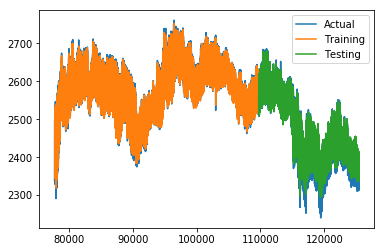

--------------------------------------------------------------------------------
Train on 25544 samples, validate on 6387 samples
Epoch 1/10
 - 12s - loss: 0.1313 - val_loss: 0.0066
Epoch 2/10
 - 4s - loss: 0.0201 - val_loss: 0.0046
Epoch 3/10
 - 3s - loss: 0.0126 - val_loss: 0.0019
Epoch 4/10
 - 3s - loss: 0.0080 - val_loss: 0.0012
Epoch 5/10
 - 4s - loss: 0.0068 - val_loss: 9.8029e-04
Epoch 6/10
 - 4s - loss: 0.0058 - val_loss: 8.3114e-04
Epoch 7/10
 - 3s - loss: 0.0048 - val_loss: 5.4348e-04
Epoch 8/10
 - 3s - loss: 0.0039 - val_loss: 3.2656e-04
Epoch 9/10
 - 4s - loss: 0.0033 - val_loss: 2.6737e-04
Epoch 10/10
 - 4s - loss: 0.0029 - val_loss: 2.2765e-04
Train Score: 13.20 RMSE
Test Score: 51.99 RMSE


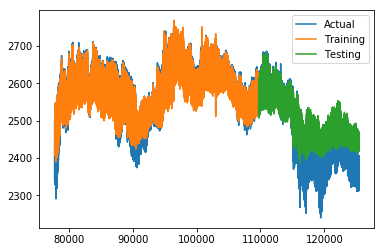

--------------------------------------------------------------------------------
Train on 25544 samples, validate on 6387 samples
Epoch 1/10
 - 9s - loss: 0.0209 - val_loss: 3.1329e-04
Epoch 2/10
 - 2s - loss: 2.5459e-04 - val_loss: 1.0666e-04
Epoch 3/10
 - 2s - loss: 1.3383e-04 - val_loss: 9.3166e-05
Epoch 4/10
 - 3s - loss: 1.1273e-04 - val_loss: 8.8238e-05
Epoch 5/10
 - 3s - loss: 1.0417e-04 - val_loss: 8.6626e-05
Epoch 6/10
 - 3s - loss: 1.0169e-04 - val_loss: 8.5941e-05
Epoch 7/10
 - 3s - loss: 1.0074e-04 - val_loss: 8.5954e-05
Epoch 8/10
 - 3s - loss: 1.0006e-04 - val_loss: 8.5472e-05
Epoch 9/10
 - 3s - loss: 9.9794e-05 - val_loss: 8.6457e-05
Epoch 10/10
 - 3s - loss: 9.9675e-05 - val_loss: 8.6087e-05
Train Score: 5.13 RMSE
Test Score: 5.78 RMSE


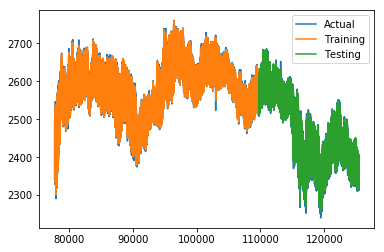

--------------------------------------------------------------------------------
Train on 25544 samples, validate on 6387 samples
Epoch 1/10
 - 11s - loss: 0.1708 - val_loss: 0.0102
Epoch 2/10
 - 1s - loss: 0.0247 - val_loss: 0.0101
Epoch 3/10
 - 1s - loss: 0.0244 - val_loss: 0.0099
Epoch 4/10
 - 1s - loss: 0.0124 - val_loss: 0.0031
Epoch 5/10
 - 1s - loss: 0.0013 - val_loss: 1.3309e-04
Epoch 6/10
 - 1s - loss: 1.7249e-04 - val_loss: 1.1983e-04
Epoch 7/10
 - 2s - loss: 1.5102e-04 - val_loss: 1.0513e-04
Epoch 8/10
 - 1s - loss: 1.2997e-04 - val_loss: 1.7394e-04
Epoch 9/10
 - 2s - loss: 1.4348e-04 - val_loss: 2.1272e-04
Epoch 10/10
 - 2s - loss: 1.3343e-04 - val_loss: 1.3512e-04
Train Score: 6.02 RMSE
Test Score: 8.55 RMSE


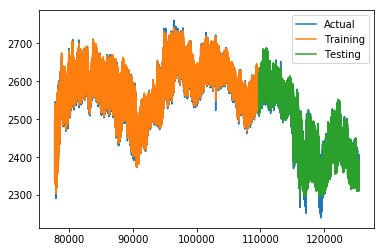

--------------------------------------------------------------------------------
Train on 25544 samples, validate on 6387 samples
Epoch 1/10
 - 13s - loss: 0.0303 - val_loss: 5.1504e-04
Epoch 2/10
 - 2s - loss: 0.0017 - val_loss: 1.1832e-04
Epoch 3/10
 - 2s - loss: 0.0014 - val_loss: 9.3709e-05
Epoch 4/10
 - 2s - loss: 0.0012 - val_loss: 1.3008e-04
Epoch 5/10
 - 2s - loss: 0.0010 - val_loss: 1.1094e-04
Epoch 6/10
 - 2s - loss: 9.0088e-04 - val_loss: 1.1383e-04
Epoch 7/10
 - 2s - loss: 8.0851e-04 - val_loss: 8.9483e-05
Epoch 8/10
 - 1s - loss: 7.3213e-04 - val_loss: 9.3655e-05
Epoch 9/10
 - 1s - loss: 6.7852e-04 - val_loss: 1.0497e-04
Epoch 10/10
 - 1s - loss: 6.3651e-04 - val_loss: 8.3887e-05
Train Score: 5.28 RMSE
Test Score: 10.32 RMSE


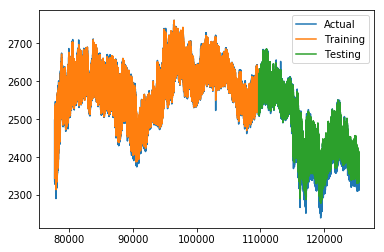

In [124]:
model1=model1()
model2=model2()
model3=model3()
model4=model4()
model5=model5()

for model in [model1, model2, model3, model4, model5]:
    print("-" * 80)
    model.compile(loss='mean_squared_error', optimizer='adam')
    history=model.fit(trainX, trainY, epochs=10, batch_size=256, verbose=2,validation_split=0.2)
    trainPredict=[]
    testPredict=[]
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

# We have to invert the predictions before calculating error to so that reports will be in same units as our original data

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_ = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_ = scaler.inverse_transform([testY])


    trainScore = math.sqrt(mean_squared_error(trainY_[0], trainPredict[:, 0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_[0], testPredict[:, 0]))
    print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 
 # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

    plt.plot(df['last'], label='Actual')
    plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
    plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
    plt.legend(loc='best')
    plt.show()
   

<b>Discussion</b>

No optimization was performed in this study. Experiments were performed with 10 epoch. According to the current situation, the most successful algorithm is the model developed with GRU.

<b>References:</b>
  
    * This study was adapted from the work of Sudharsan Ravichandiran. In addition to the present study, 4 different models were added and comparative analysis was performed. I thank Sudharsan Ravichandiran.
    https://github.com/sudharsan13296/Bitcoin-price-Prediction-using-LSTM